# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [48]:
# # The following libraries might be useful
# !pip install -q langchain-openai
# !pip install -U -q langchain-community
# !pip install -U -q langchain-chroma
# !pip install -U -q datasets
# !pip install -U -q ragas
# !pip install -U -q rouge_score
# !pip install -U -q swifter
# !pip install -U -q swifter[notebook]
# !pip install -U -q swifter[groupby]
# !pip install -U -q jq
# !pip install -U -q evaluate
# !pip install -U -q accelerate
# !pip install -U -q torch

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
# import evaluate
from json import JSONDecoder
from datasets import Dataset
from collections import Counter

from pprint import pprint
from tqdm import tqdm
tqdm.pandas()

import re
from nltk.corpus import stopwords
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

from sentence_transformers import SentenceTransformer, CrossEncoder
from transformers import pipeline

from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import JSONLoader
from langchain_community.llms import HuggingFacePipeline
from langchain_core.prompts import (
    ChatPromptTemplate,
    PromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain


import openai
from openai import OpenAI
from ragas.llms import LangchainLLMWrapper

import chromadb
chroma_client= chromadb.PersistentClient()
chroma_cache= chromadb.Client()

from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall

import warnings
warnings.filterwarnings('ignore')

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [50]:
# Load the files as documents
fpath= r"rag_legal/corpus"

loader= DirectoryLoader(path= fpath, 
                        loader_cls= TextLoader,
                        loader_kwargs= {'autodetect_encoding': True},
                        use_multithreading= True, 
                        show_progress= True, 
                        recursive= True, 
                        silent_errors= True)

docs= pd.Series(loader.load())

print('Total documents loaded: ', len(docs))

100%|██████████| 698/698 [00:01<00:00, 432.68it/s]

Total documents loaded:  698


In [51]:
# Printing a random document sample
idx= np.random.randint(0, len(docs)+1)
header= docs[idx].metadata['source'].split('\\')[-2:]
text= docs[idx].page_content
print(header)
pprint(text)

['contractnli', 'SE_NDCA_and_PRE-QUAL_PACKAGE_March-2016.txt']
('Non Disclosure and Confidentiality Agreement\n'
 'This Confidentiality Agreement (“Agreement”), entered into as of ________ '
 '_____(“Effective Date”), is by and between Signal Energy, LLC, (including '
 'its affiliates, EMJ Corporation, Signal Wind Energy, LLC and Signal Solar, '
 'LLC), having its principal offices at 2034 Hamilton Place Blvd., Suite 400, '
 'Chattanooga, TN 37421 (“Company”), and '
 '________________________________________________ and its affiliates, '
 '(“Counterparty”).\n'
 'WHEREAS, Company and Counterparty shall each be referred to as a “Party” and '
 'collectively as the “Parties”;\n'
 'WHEREAS the Parties desire to hold discussions and exchange information '
 'regarding Counterparty’s equipment and/or services to Company related to '
 'wind energy facilities, solar energy facilities, energy facilities, business '
 'evaluation, funding, purchase agreement or other business transaction '
 '(colle

#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [52]:
# Clean and preprocess the data
pos= spacy.load('en_core_web_sm', disable= ['parser', 'ner'])
stop_pattern= '|'.join([f'\\b{w}\\b' for w in stopwords.words('english')])

def clean_text(text):
    
    text_out= text.lower()                                              # convert to lower case
    text_out= re.sub('\w+@\w+\.\w+', '', text_out)                      # remove emails
    text_out= re.sub('[\(\{\[]\w*[\)\}\]]', '', text_out)               # remove roman numerals
    text_out= re.sub('[^a-z,.\':;"\n]', ' ', text_out)                  # remove special characters and numbers

    # Remove stopwords
    text_out= re.sub(stop_pattern, '', text_out)
    
    text_out= re.sub('[ ]{2,}', ' ', text_out)                          # remove excess spaces
    text_out= re.sub('[\n]{3,}', '', text_out)                          # remove excess newlines

    return text_out

# Sample cleaned document text
text_cleaned= clean_text(text)
pprint(clean_text(text_cleaned))


('non disclosure confidentiality agreement\n'
 ' confidentiality agreement agreement , entered effective date , signal '
 'energy, llc, including affiliates, emj corporation, signal wind energy, llc '
 'signal solar, llc , principal offices hamilton place blvd., suite , '
 'chattanooga, tn company , affiliates, counterparty .\n'
 'whereas, company counterparty shall referred party collectively parties ;\n'
 'whereas parties desire hold discussions exchange information regarding '
 'counterparty equipment services company related wind energy facilities, '
 'solar energy facilities, energy facilities, business evaluation, funding, '
 'purchase agreement business transaction collectively transactions ;\n'
 'whereas, course evaluating transactions necessary company disclosing party '
 'release certain confidential information defined counterparty receiving '
 'party ;\n'
 ', therefore, consideration mutual promises covenants made herein, receipt '
 'sufficiency hereby acknowledged, intent 

#### Semantic similarity based chunking

In [53]:
# Functions for extracting data

def extract_doctype(doc):

    doctyp= doc.metadata['source'].split('\\')[-2]       # Extract metadata
    return doctyp

def extract_docheader(doc):

    docheader= doc.metadata['source'].split('\\')[-1]       # Extract metadata
    return docheader

def preprocess_doc(doc):

    text= doc.page_content
    return clean_text(text)

In [54]:
# Extract metadata (document type, filename) and text
doc_type= docs.swifter.apply(extract_doctype)
doc_header= docs.swifter.apply(extract_docheader)
doc_text= docs.swifter.apply(preprocess_doc)

Pandas Apply:   0%|          | 0/698 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/698 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/698 [00:00<?, ?it/s]

In [55]:
# Create preliminary document table for EDA
doc_table= pd.concat([doc_type, doc_header, doc_text], axis= 1)
doc_table.columns= ['doc_type', 'doc_filename', 'doc_text']
doc_table.head()

,doc_type,doc_filename,doc_text
0,contractnli,12032018_NDA_The_20Munt_EN.txt,confidentiality agreement\n confidentiality ag...
1,contractnli,01_Bosch-Automotive-Service-Solutions-Mutual-N...,mutual non disclosure agreementsubject matter:...
2,contractnli,5-NSK-Confidentiality-Agreement-for-Suppliers.txt,non disclosure agreement\n agreement effective...
3,contractnli,AGProjects-NDA.txt,"please fill contact details, sign last page fa..."
4,contractnli,ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt,non disclosure agreement\nr \n pls. fill form ...


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [56]:
# Calculate the average, maximum and minimum document length.

doc_table['text_len']= doc_table['doc_text'].progress_apply(lambda x: len([w for w in str(x).split() if w not in '.,;"\'']))

Pandas Apply:   0%|          | 0/698 [00:00<?, ?it/s]

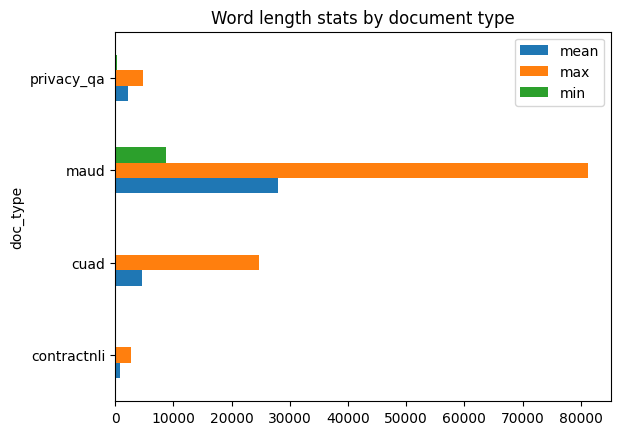

In [57]:
title= 'Word length stats by document type'
doc_table.groupby('doc_type')['text_len'].aggregate(['mean', 'max', 'min']).plot.barh(title= title)
plt.show()

#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

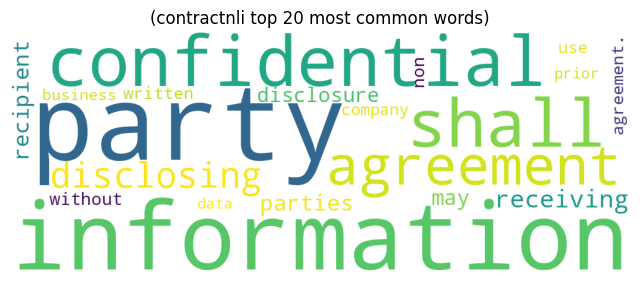

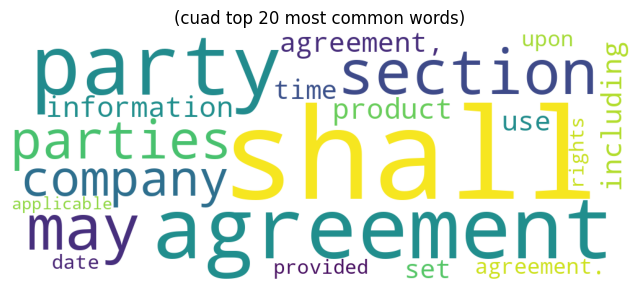

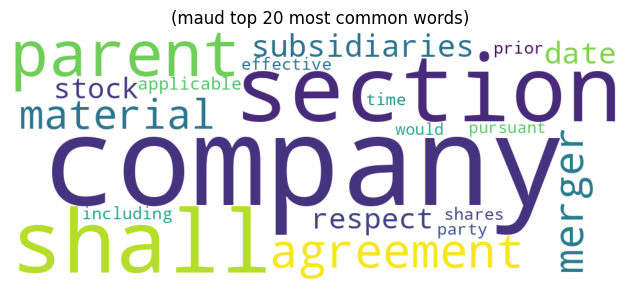

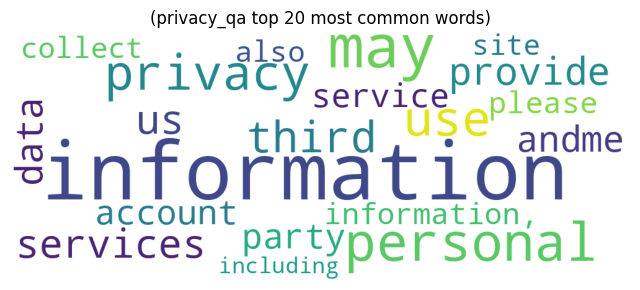

In [74]:
# Find frequency of occurence of words
# Most common words

for doc_typ in doc_table['doc_type'].unique():
    texts= doc_table.loc[doc_table['doc_type'] == doc_typ, 'doc_text']
    text_string= ' '.join(texts)
    word_freq= Counter([word for word in text_string.split() if word not in ",.;'\""])

    wordcloud_true = WordCloud(width=1000, 
        height=400, max_words=20, background_color="white").generate_from_frequencies(word_freq)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud_true, interpolation=None)
    plt.axis("off")
    plt.title(f'({doc_typ} top 20 most common words)')
    plt.show()

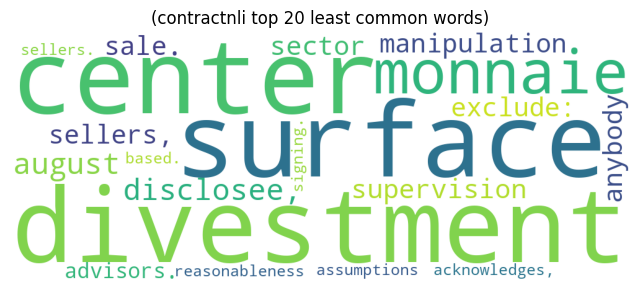

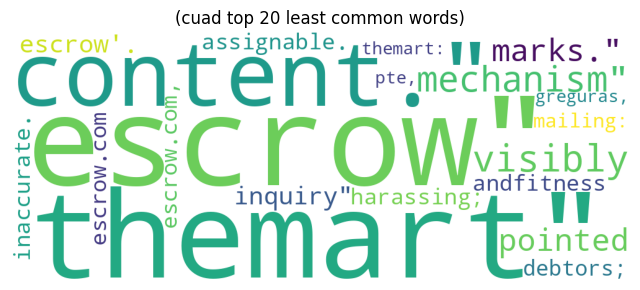

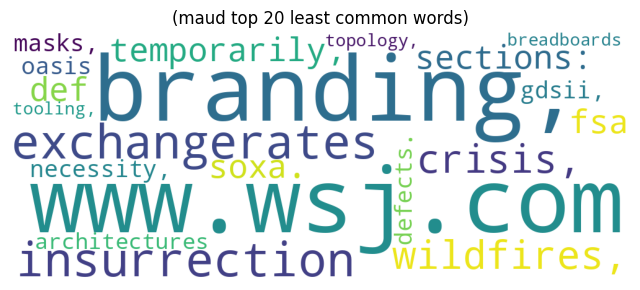

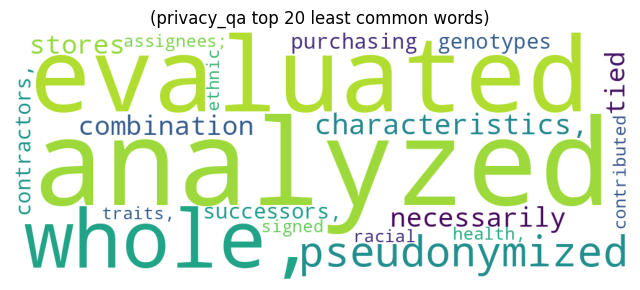

In [75]:
# Least common words

for doc_typ in doc_table['doc_type'].unique():
    texts= doc_table.loc[doc_table['doc_type'] == doc_typ, 'doc_text']
    text_string= ' '.join(texts)
    word_freq= Counter([word for word in text_string.split() if word not in ",.;'\""])
    n= len(word_freq)
    word_freq= {key: 1 - val/n for key, val in word_freq.items()}

    wordcloud_true = WordCloud(
        width=1000, height=400, max_words=20, background_color="white").generate_from_frequencies(word_freq)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud_true, interpolation=None)
    plt.axis("off")
    plt.title(f'({doc_typ} top 20 least common words)')
    plt.show()

#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

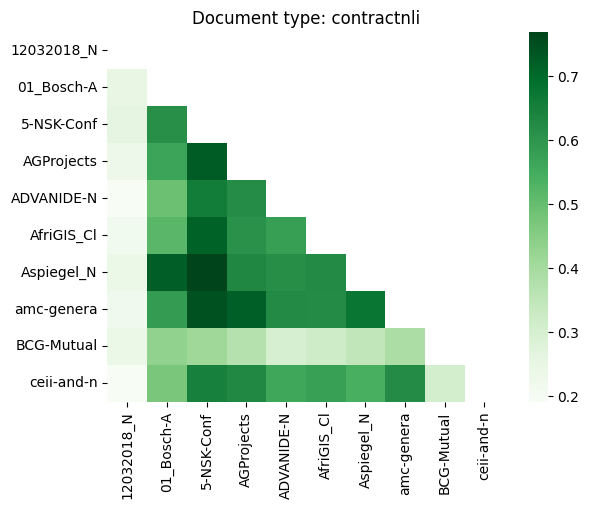

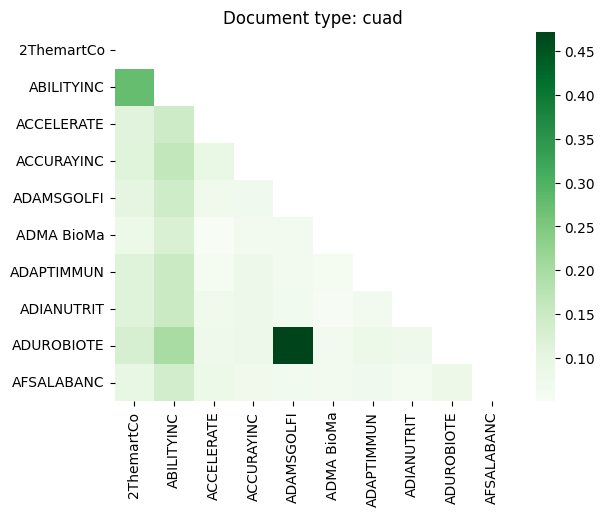

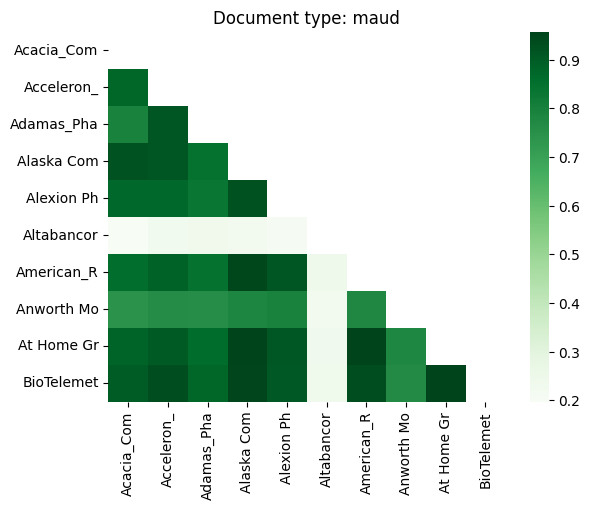

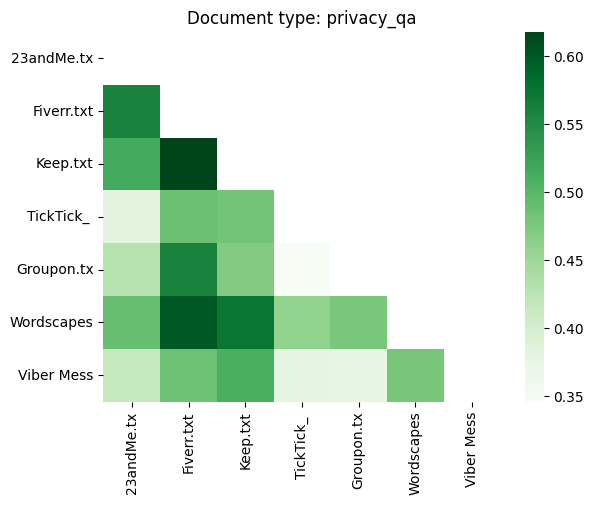

In [76]:
# Transform the page contents of documents
tfidf = TfidfVectorizer(smooth_idf= True)

for doc_typ in doc_table['doc_type'].unique():

    text_list= doc_table.loc[doc_table['doc_type'] == doc_typ, 'doc_text'].iloc[:10].to_list()
    files= doc_table.loc[doc_table['doc_type'] == doc_typ, 'doc_filename'].iloc[:10].to_list()
    X= tfidf.fit_transform(text_list).todense()

# Compute similarity scores
    X= X / np.c_[np.linalg.norm(X, axis= 1)]                        # converting to unit vectors
    cos_sim=  np.dot(X, X.T)                                        # using cosine similarity scores

    files= [fname[:10] for fname in files]
    sns.heatmap(cos_sim, cmap= 'Greens', mask= np.triu(cos_sim), xticklabels= files, yticklabels= files)
    plt.title(f'Document type: {doc_typ}')
    plt.show()


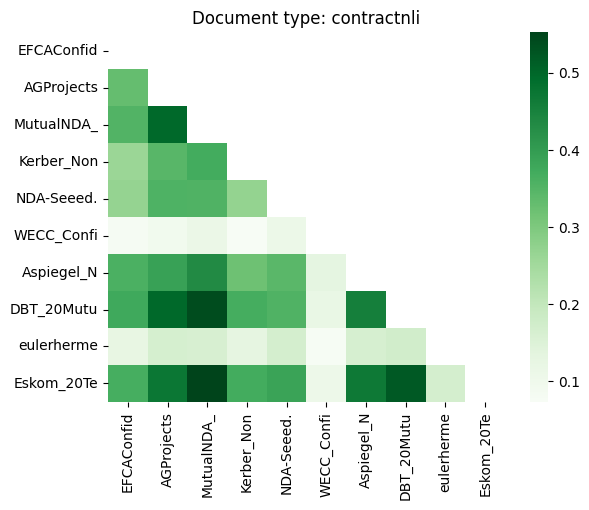

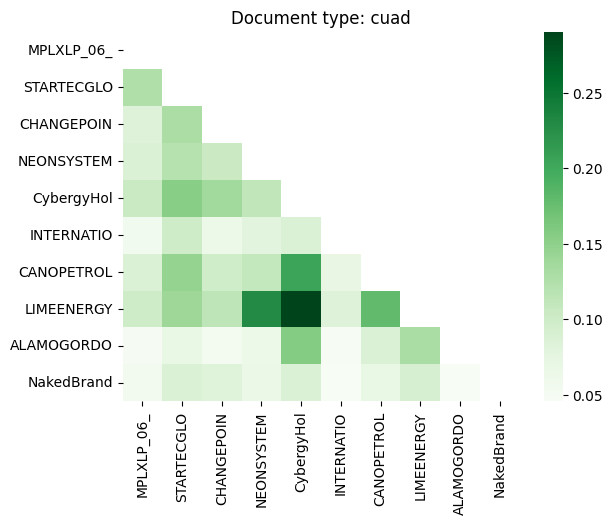

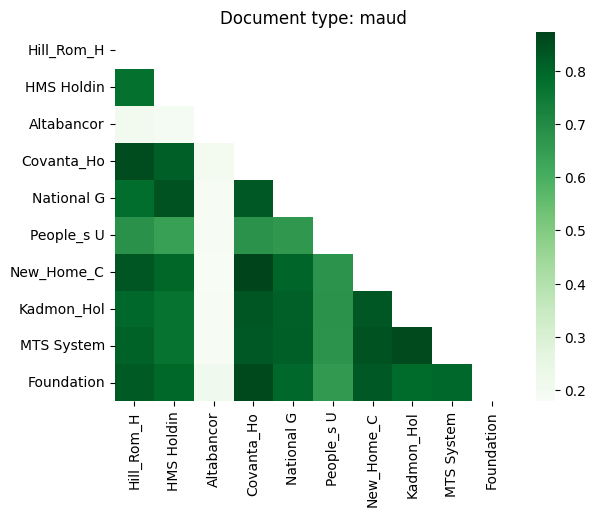

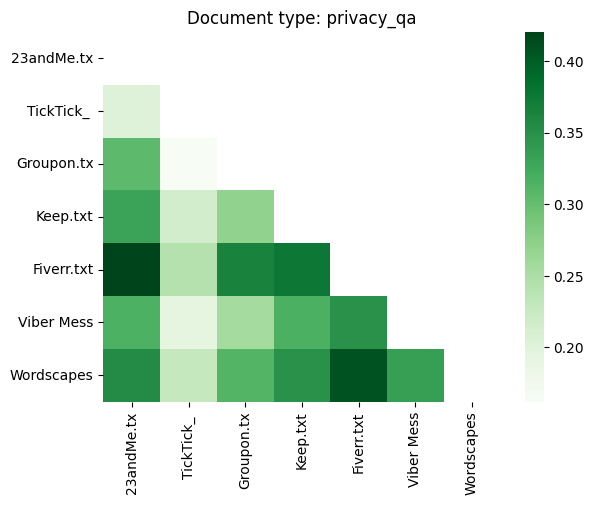

In [77]:
# Similarity between 10 random documents belonging to the same category

tfidf = TfidfVectorizer(ngram_range= (1, 3), smooth_idf= True)

for doc_typ in doc_table['doc_type'].unique():

    docs= doc_table.loc[doc_table['doc_type'] == doc_typ, 'doc_text']
    files= doc_table.loc[doc_table['doc_type'] == doc_typ, 'doc_filename']

    if len(docs) > 10:
        random_idx= np.random.choice(docs.index, 10, replace= False)
    else:
        random_idx= np.random.choice(docs.index, len(docs), replace= False)
        
    text_list= docs.loc[random_idx].to_list()
    files= files.loc[random_idx].to_list()
    X= tfidf.fit_transform(text_list).todense()

# Compute similarity scores
    X= X / np.c_[np.linalg.norm(X, axis= 1)]                        # converting to unit vectors
    cos_sim=  np.dot(X, X.T)                                        # using cosine similarity scores

    files= [fname[:10] for fname in files]
    sns.heatmap(cos_sim, cmap= 'Greens', mask= np.triu(cos_sim), xticklabels= files, yticklabels= files)    # plotting cosine similarity in heatmap
    plt.title(f'Document type: {doc_typ}')
    plt.show()


In [78]:
# create a list of 10 random integers

random_idx= np.random.choice(doc_table.index, 10, replace= False)

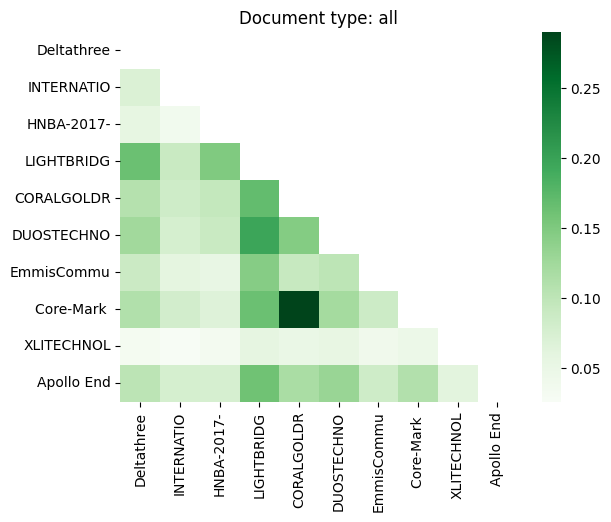

In [79]:
# Compute similarity scores for 10 random documents
# Transform the page contents of documents

tfidf = TfidfVectorizer(ngram_range= (1, 3), smooth_idf= True)

text_list= doc_table.loc[random_idx, 'doc_text'].to_list()
files= doc_table.loc[random_idx, 'doc_filename'].to_list()
X= tfidf.fit_transform(text_list).todense()

X= X / np.c_[np.linalg.norm(X, axis= 1)]            # converting to unit vectors
cos_sim= np.dot(X, X.T)

files= [fname[:10] for fname in files]
sns.heatmap(cos_sim, cmap= 'Greens', mask= np.triu(cos_sim), xticklabels= files, yticklabels= files)
plt.title('Document type: all')
plt.show()

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [ ]:
sent_legal= SentenceTransformer('nlpaueb/legal-bert-base-uncased')
pos_sent= spacy.load('en_core_web_sm')

No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.


In [ ]:
# Semantic similarity based chunking

def chunk_similar(text, model, sim_threshold= 0.5, max_sents= 10):

    def cosine_sim(v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    # Inferred parameters
    sent_list = list(pos_sent(text).sents)
    all_clusters, idx= [], 0

    while idx < len(sent_list)-1:
        cluster, count= [], 0
        sent= sent_list[idx].text
        cluster.append(sent)
        v1= model.encode(sent, convert_to_numpy= True)
        
        for next_idx in range(idx + 1, len(sent_list)):
            sent_nxt= sent_list[next_idx].text
            v2= model.encode(sent_nxt, convert_to_numpy= True)

            if cosine_sim(v1, v2) < sim_threshold:
                break
            elif count > max_sents:
                break
            else:
                cluster.append(sent_nxt)

            count += 1

        all_clusters.append(cluster)
        idx = next_idx
            
    return all_clusters

In [ ]:
def chunk_docs(doc, chunk_func):

    chunks= pd.Series(chunk_func(doc['doc_text'], model= sent_legal))
    n_chunks= len(chunks)
    doc_type= pd.Series(np.tile(doc['doc_type'], n_chunks))
    doc_name= pd.Series(np.tile(doc['doc_filename'], n_chunks))
    doc_len= pd.Series(np.tile(doc['text_len'], n_chunks))
    doc_chunked= pd.concat([doc_type, doc_name, doc_len, chunks], axis= 1)
    doc_chunked.columns= ['doc_type', 'doc_filename', 'text_len', 'doc_chunks']

    return doc_chunked

In [ ]:
doc_chunks= doc_table.progress_apply(lambda x: chunk_docs(x, chunk_func= chunk_similar), axis= 1)

Pandas Apply:   0%|          | 0/698 [00:00<?, ?it/s]

In [ ]:
doc_table_chunked= pd.DataFrame()

for doc_chunk in tqdm(doc_chunks):
    doc_table_chunked= pd.concat([doc_table_chunked, doc_chunk], axis= 0)

100%|██████████| 698/698 [00:00<00:00, 6555.65it/s]


In [ ]:
doc_table_chunked.to_csv('doc_table_chunked.csv')

In [ ]:
doc_table_chunked = pd.read_csv('doc_table_chunked.csv', index_col= 0)
doc_table_chunked.reset_index(drop= True, inplace= True)
doc_table_chunked.head()

,doc_type,doc_filename,text_len,doc_chunks
0,contractnli,12032018_NDA_The_20Munt_EN.txt,526,['confidentiality agreement\n confidentiality ...
1,contractnli,12032018_NDA_The_20Munt_EN.txt,526,['event disclosee representatives becomes lega...
2,contractnli,12032018_NDA_The_20Munt_EN.txt,526,['.\n']
3,contractnli,12032018_NDA_The_20Munt_EN.txt,526,['signature\n department deloitte consulting a...
4,contractnli,01_Bosch-Automotive-Service-Solutions-Mutual-N...,1263,['mutual non disclosure agreementsubject matte...


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [2]:
# Fetch your OPENAI API Key as an environment variable

with open('OpenAI_API_Key.txt', 'r') as key:
    os.environ['OPENAI_API_KEY']= key.readline()

openai.api_key= os.getenv('OPENAI_API_KEY')

embedder= OpenAI()

In [ ]:
# Initialise an embedding function

def get_embeddings_batch(text_batch):
    word_vecs= embedder.embeddings.create(
        input= text_batch,
        model= 'text-embedding-3-small',
        encoding_format= 'float',
    )
    return [np.array(vec.embedding) for vec in word_vecs.data]


In [ ]:
# Generate embeddings for all chunks

batch_size= 200
embeddings= []

for i in tqdm(range(0, len(doc_table_chunked), batch_size)):
    batch= doc_table_chunked['doc_chunks'].iloc[i: i + batch_size].tolist()
    batch_embeds= get_embeddings_batch(batch)
    embeddings.extend(batch_embeds)

doc_table_chunked['doc_embeddings'] = embeddings

100%|██████████| 152/152 [12:05<00:00,  4.77s/it]


In [ ]:
# Save embeddings dataframe
doc_table_chunked.to_pickle("doc_table_embed.pkl")

In [ ]:
# Load it back later
doc_table_embed = pd.read_pickle("doc_table_embed.pkl")

In [ ]:
# convert to list
doc_table_embed['doc_embeddings']= doc_table_embed['doc_embeddings'].apply(list)

#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [ ]:
# chroma_client.delete_collection('RAG_Legal')
# chroma_cache.delete_collection('RAG_Legal_Cache')

In [ ]:
# Add Chunks to vector DB

collection= chroma_client.get_or_create_collection(name= 'RAG_Legal')           # main collection
cache_collection= chroma_cache.get_or_create_collection('RAG_Legal_Cache')      # cache collection

# Process metadata
metadatas= ((doc_table_embed['doc_type'] + ',' + doc_table_embed['doc_filename']).str.split(','))
metadatas= metadatas.apply(lambda x: {'doc_type': x[0], 'doc_name': x[1]})

# Add documents to main collection
batch_size= 1000

for i in tqdm(range(0, len(doc_table_embed), batch_size)):
    batch= doc_table_embed.iloc[i: i + batch_size]

    collection.add(
        ids= [str(i) for i in batch.index],
        embeddings= batch['doc_embeddings'].to_list(),
        documents= batch['doc_chunks'].to_list(),
        metadatas= metadatas[i:i + batch_size].to_list(),
    )

collection.peek(2)

100%|██████████| 31/31 [00:33<00:00,  1.10s/it]


{'ids': ['0', '1'],
 'embeddings': array([[-0.00045665,  0.00427203,  0.06508958, ..., -0.00371298,
         -0.0306883 ,  0.00604413],
        [-0.00745246,  0.04116998,  0.04513346, ...,  0.01489097,
         -0.02803745,  0.00360412]]),
 'documents': ["['confidentiality agreement\\n confidentiality agreement agreement prepared behalf bpost sa nv, limited liability company public law, city brussels sellers regard divestment respective surface areas sale munt center centre monnaie munt .\\n ', 'consideration sellers agreeing disclose confidential information confidential information candidate disclosee , latter hereby undertakes sellers disclosee, keep confidential confidential information received time.', 'disclosee procure prior disclosure person including professional advisor confidential information, person made aware provisions agreement fact disclosee liable.\\n ', 'disclosee acknowledges confidential information, far relates bpost sa nv, could price sensitive information ensure

In [60]:
collection= chroma_client.get_collection('RAG_Legal')
cache_collection= chroma_cache.get_or_create_collection('RAG_Legal_Cache')      # cache collection
# cache_collection= chroma_cache.get_collection('RAG_Legal_Cache')

In [ ]:
cross_encoder= CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')

# Function for retrieving documents either from cache or main collection
def retrieve_docs(query, n_searches= 10, n_tops= 5, cache_threshold= 0.2):

    # embed query
    response= embedder.embeddings.create(
    model= 'text-embedding-3-small',
    input= query,
    )
    query_vec= response.data[0].embedding

    # check for results in cache collection
    cache_results= cache_collection.query(
        query_embeddings= query_vec,
        include= ['documents', 'metadatas', 'distances'],
        n_results= 1,
    )

    if cache_results['documents'][0] == [] or cache_results['distances'][0][0] > cache_threshold:

        # retrieve documents from main collection
        results= collection.query(
            query_embeddings= query_vec,
            include= ['distances', 'documents', 'metadatas'],
            n_results= n_searches,
        )

        # add results to cache
        cache_collection.add(
            ids= [query],
            documents= [query],
            embeddings= [query_vec],
            metadatas= [
                    {
                        'documents': json.dumps(results['documents'][0]),
                        'metadatas': json.dumps(results['metadatas'][0]),
                        'distances': json.dumps(results['distances'][0]),
                    }
                ],
        )

        # create retrieved dataframe
        docs= pd.DataFrame([{'documents': result.strip('[]')} for result in results['documents'][0]])
        metadata= pd.DataFrame(results['metadatas'][0])
        dist= pd.Series(results['distances'][0], name= 'distances')
        results_df= pd.concat([metadata, dist, docs], axis= 1)

    else:
        
        # retrieve results from cache in dataframe format
        results_df = pd.DataFrame()
        for key, val in cache_results['metadatas'][0][0].items():
            if key == 'metadatas':
                retrieved= pd.DataFrame(json.loads(val))
            else:
                retrieved= pd.Series(json.loads(val), name= key)
                
            results_df= pd.concat([results_df, retrieved], axis= 1)

    # rerank on cross_encoding scores
    cross_inputs = [[query, response] for response in results_df['documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)
    results_df['reranked_scores'] = cross_rerank_scores
    results_df.sort_values(by= 'reranked_scores', ascending= False, inplace= True)

    return results_df.iloc[:n_tops, :]


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [ ]:
# Create a RAG chain
query= "Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the expiration date of this contract?"

system_template = """"
    You are a helpful legal expert who gives accurate answers to user's questions on legal queries.

    Guidelines:
    1. You are given a corpus of legal documents in the form of a DataFrame (attached below) based on the user query.
    2. The 'documents' column of the DataFrame contains the texts which provide the context to the answer.
    3. Try to use all documents given in the DataFrame.
    4. Answer based on the context provided using technical and legal language. 
    5. Try not to repeat yourself while answering.
    6. DO NOT mention that the answer you found was based on any corpus provided to you. Instead answer directly.

    --------------
    Legal corpus: {df}
    --------------
"""
system_prompt= SystemMessagePromptTemplate.from_template(system_template)

human_template= '{query}'
human_prompt= HumanMessagePromptTemplate.from_template(human_template)

chat_prompt= ChatPromptTemplate.from_messages([system_prompt, human_prompt])

llm_chat= ChatOpenAI(api_key= os.getenv('OPENAI_API_KEY'))

chain= LLMChain(
    llm= llm_chat,
    prompt= chat_prompt,
)

response= chain.run(
    query= query,
    df= retrieve_docs(query),
)

pprint(response)

('The expiration date of the Marketing Affiliate Agreement between Birch First '
 'Global Investments Inc. and Mount Knowledge Holdings Inc. is not explicitly '
 'mentioned in the provided legal documents. However, based on the terms of '
 'the agreement, it is stated that the agreement shall expire upon the '
 'completion of the investment cycle.')


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [65]:
# Create a function for question answering

def answer_query(query):

    system_template = """"
        You are a helpful legal expert who gives accurate answers to user's questions on legal queries.

        Guidelines:
        1. You are given a corpus of legal documents in the form of a DataFrame (attached below) based on the user query.
        2. The 'documents' column of the DataFrame contains the texts which provide the context to the answer.
        3. Try to use all documents given in the DataFrame.
        4. Answer based on the context provided using technical and legal language. 
        5. Try not to repeat yourself while answering.
        6. DO NOT mention that the answer you found was based on any corpus provided to you. Instead answer directly.

        --------------
        Legal corpus: {df}
        --------------
    """
    system_prompt= SystemMessagePromptTemplate.from_template(system_template)

    human_template= '{query}'
    human_prompt= HumanMessagePromptTemplate.from_template(human_template)

    chat_prompt= ChatPromptTemplate.from_messages([system_prompt, human_prompt])

    llm_chat= ChatOpenAI(api_key= os.getenv('OPENAI_API_KEY'), model= 'gpt-4.1-2025-04-14')

    chain= LLMChain(
        llm= llm_chat,
        prompt= chat_prompt,
    )

    response= chain.run(
        query= query,
        df= retrieve_docs(query),
    )
    context= ' '.join(retrieve_docs(query)['documents'].to_list()).strip('[]')

    return {'answer': response, 'context': context}

In [66]:
# Example question
question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"
question1= "Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the expiration date of this contract?"

pprint(answer_query(question)['answer'])

('Yes, the Non-Disclosure Agreement (NDA) between CopAcc and ToP Mentors '
 'expressly indicates that the Agreement does not grant the Receiving Party '
 'any rights to the Confidential Information. It is clearly articulated that, '
 'without limiting the foregoing, the Receiving Party does not acquire by '
 'implication or otherwise, any right, title, or interest in or to the '
 'Confidential Information, except for the limited purpose of evaluating or '
 'engaging in discussions pertaining to the defined purpose of the NDA. This '
 'provision is a standard clause in NDAs and is designed to ensure that '
 'disclosure of confidential information does not result in any unintended '
 'transfer of intellectual property or proprietary rights to the Receiving '
 'Party. The Receiving Party is obligated to use the Confidential Information '
 'solely for the designated purpose specified in the Agreement and is not '
 'authorized to use, reproduce, or exploit the Confidential Information for '

## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [67]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set
fpath= r"benchmarks"

# Load benchmark data
loader= DirectoryLoader(
    path= fpath,
    loader_cls= JSONLoader,
    loader_kwargs= {'jq_schema': '.tests[]', 'text_content': False},
    use_multithreading= True,
    show_progress= True,
    recursive= True,
    silent_errors= True,
)
    # benchmarks[schema_key]= pd.Series(loader.load())
benchmarks= pd.Series(loader.load())

100%|██████████| 4/4 [00:00<00:00, 18.31it/s]


In [68]:
def extract_json(doc):

    query= json.loads(doc.page_content)['query']
    snippets= json.loads(doc.page_content)['snippets']
    answer= ' '.join([snippet['answer'] for snippet in snippets])
    doc_type= ' '.join({snippet['file_path'].split('/')[0] for snippet in snippets})
    doc_name= ' '.join({snippet['file_path'].split('/')[1] for snippet in snippets})

    return query, answer, doc_type, doc_name

benchmark_df= benchmarks.map(extract_json).apply(pd.Series)
benchmark_df.columns= ['question', 'ground_truth', 'doc_type', 'doc_name']

benchmark_df.head()

,question,ground_truth,doc_type,doc_name
0,"Consider ""Fiverr""'s privacy policy; who can se...","In addition, we collect information while yo...",privacy_qa,Fiverr.txt
1,"Consider ""Fiverr""'s privacy policy; who can se...","In other words, when you access the Site we ar...",privacy_qa,Fiverr.txt
2,"Consider ""Fiverr""'s privacy policy; what type ...",We collect information that you provide us o...,privacy_qa,Fiverr.txt
3,"Consider ""Fiverr""'s privacy policy; how is my ...",We take great care in maintaining the securi...,privacy_qa,Fiverr.txt
4,"Consider ""Fiverr""'s privacy policy; who can se...","In other words, when you access the Site we ar...",privacy_qa,Fiverr.txt


In [69]:
# Create random benchmark sample dataframe of 100 questions of each type
sample_benchmark_df = pd.DataFrame()

for doc_type in benchmark_df['doc_type'].unique():
    sample_benchmark_df= pd.concat([
        sample_benchmark_df, 
        benchmark_df.loc[benchmark_df['doc_type'] == doc_type].sample(100)], 
        axis= 0)
    
sample_benchmark_df.reset_index(drop= True, inplace= True)

#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [70]:
# Sample QnA
i= np.random.randint(0, len(sample_benchmark_df)+1)
print(sample_benchmark_df.loc[i]['question'])
print()
print(sample_benchmark_df.loc[i]['doc_name'])
pprint(sample_benchmark_df.loc[i]['ground_truth'])
print('RAG response','-' * 60)
pprint(answer_query(sample_benchmark_df.loc[i]['question'])['answer'])

Consider Eskom's Confidentiality and Non-Disclosure Agreement; Does the document allow the Receiving Party to share some Confidential Information with their employees?

Eskom%20Template%20Confidentiality%20and%20Non-disclosure%20Agreement%20Rev%204%20Effective%20August%202017_11.txt
('6.5. Notwithstanding anything to the contrary contained in this Agreement, '
 'the Parties agree that the Confidential Information may be disclosed by the '
 'Receiving Party to its respective employees, agents, officers, directors, '
 'subsidiaries, associated companies, shareholders and advisers (including but '
 'not limited to professional financial advisers, legal advisers and auditors) '
 '("Representatives") on a need-to-know basis and for the purposes of the '
 'Project, provided that the Receiving Party, prior to making any disclosure '
 'of Confidential Information as permitted under this 6.5, procures that the '
 'proposed recipient of such Confidential Information is made aware of the '
 'term

In [71]:
# Generate responses for all queries

sample_benchmark_df= pd.concat([sample_benchmark_df, 
                                sample_benchmark_df['question'].progress_map(answer_query).apply(pd.Series)], axis= 1)


Pandas Apply:   0%|          | 0/400 [00:00<?, ?it/s]

In [72]:
sample_benchmark_df.to_csv('sample_benchmark.csv')

In [3]:
sample_benchmark_df= pd.read_csv('sample_benchmark.csv', index_col= 0)

In [4]:
# Function to evaluate the RAG pipeline

# Create evaluation dataset
eval_df= sample_benchmark_df[['question', 'answer', 'context', 'ground_truth']]
eval_df.rename({'context':'retrieved_contexts'}, inplace= True, axis= 1)
eval_df['retrieved_contexts']= eval_df['retrieved_contexts'].apply(lambda x: [x])
eval_dataset = Dataset.from_pandas(eval_df)

ragas_llm = LangchainLLMWrapper(ChatOpenAI(model= 'gpt-3.5-turbo'))


#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [5]:
# Evaluate the RAG pipeline

# RAGAS evaluation
try:
    RAGAS_score = evaluate(
        dataset= eval_dataset,
        metrics= [faithfulness, answer_relevancy, context_precision, context_recall],
        llm= ragas_llm,
        batch_size= 10,  
        show_progress= True,
    )
except Exception as e:
    print("RAGAS computation failed:", e)

RAGAS_score

Evaluating:   0%|          | 0/1600 [00:00<?, ?it/s]

Batch 1/160:   0%|          | 0/10 [00:00<?, ?it/s]

Exception raised in Job[79]: LLMDidNotFinishException(The LLM generation was not completed. Please increase the max_tokens and try again.)
Exception raised in Job[231]: LLMDidNotFinishException(The LLM generation was not completed. Please increase the max_tokens and try again.)
Exception raised in Job[259]: LLMDidNotFinishException(The LLM generation was not completed. Please increase the max_tokens and try again.)
Exception raised in Job[363]: LLMDidNotFinishException(The LLM generation was not completed. Please increase the max_tokens and try again.)


{'faithfulness': 0.5283, 'answer_relevancy': 0.9004, 'context_precision': 0.8500, 'context_recall': 0.7405}

In [6]:
# ROUGE evaluation
import evaluate

rouge= evaluate.load('rouge')

try:
    Rouge_score = rouge.compute(
        predictions=sample_benchmark_df['answer'].tolist(),
        references=sample_benchmark_df['ground_truth'].tolist()
    )

except Exception as e:
    print("ROUGE computation failed:", e)


Rouge_score

{'rouge1': 0.278529086521877,
 'rouge2': 0.07374735378056448,
 'rougeL': 0.15961191164817043,
 'rougeLsum': 0.20411685828437284}

In [12]:
# Bleu evaluation
smoother= SmoothingFunction().method4

gen_tokens= sample_benchmark_df['answer'].map(word_tokenize).to_list()
ref_tokens= sample_benchmark_df['ground_truth'].map(word_tokenize).to_list()

Bleu_score= corpus_bleu(
    list_of_references= ref_tokens,
    hypotheses= gen_tokens,
    weights= (0.25, 0.25, 0.25, 0.25),
    smoothing_function= smoother
)

Bleu_score

0.00023373621960011615

## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

Lisguistic insights:
1. Merger and Aquisition type legal texts have the largest volume while Non-Disclosure agreements have the smallest text volume
2. Legal contracts have the least similarity between themselves, suggesting that each contract is unique to itself
3. 

Chunking strategy:
1. Chunking text based on sematic similarity between sentences results in higher context precision and context recall. But it takes a longer time to perform sematic chunking
2. A cosine similarity threshold of 0.5 gives a good balance between chunk length and context similarity
3. Usage of an LLM trained on legal text improves contextual similarity within chunks and improves retrieval accuracy

Retrieval strategy:
1. Cross-encoder based re-ranking improves relevance of retrieved documents with respect to the input query
2. It is observed that 5 re-ranked documents out of 10 gives more relevant context for LLM generation

Embedding strategy:
1. Using a separate cache of FAQs improves performance of retrieval process

Prompting strategy:
1. Prompting LLM to use only retrieved documents and use legal-technical terms in answering questions reduces hallucinations
2. Using better LLM improves quality of answers at the cost of reduced speed of execution. GPT-3.5-Turbo provides the right balance between speed and quality for RAG based applications

Overall RAG processflow
1. Use of batching in RAG pipeline is an important performance improver at various levels of the process workflow
2. Saving data between intermediate steps helps save time

##### Scores

RAGAS:
1. Faithfullness: 0.53      (some overgeneration, [gpt-3.5-turbo ~ 0.3])
2. Relevancy: 0.9           (direct to-the-point answers)
3. Precision: 0.85          (good retrieval)
4. Recall: 0.74             (few shot training may be needed)

ROUGE:
1. Unigram: 0.27        (fair lexical similarity with ground truth)
2. Bigram: 0.07         (low usage of matching word pairs)
3. Long: 0.16           (modest structural similarity)
4. Summary: 0.2         (fair attempt at summarizing concept)

Bleu
1. 0.0002       (indication of paraphrasing, length mismatch and misalignment of longer n-grams)